# Εργασία Αναλυτικής Δεδομένων 2024
---
### Βήμα 1: Προεπεξεργασία Δεδομένων

In [300]:
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from pandas.plotting import boxplot
from sklearn.preprocessing import RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

#### Ρυθμίσεις

In [301]:
pd.options.mode.copy_on_write = True

---

### Ανάγνωση Βάσης Δεδομένων
#### Όνομα: Bank Marketing Data Set (https://archive.ics.uci.edu/dataset/222/bank+marketing)

In [302]:
data = pd.read_csv('bank-full.csv', sep=';')

#### Πρώτη γνωριμία με τα Δεδομένα

In [303]:
# data

#### Μέγεθος και Δομή Δεδομένων

In [304]:
data.shape

(45211, 17)

In [305]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [306]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [307]:
data.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


#### Διαγραφή Διπλότυπων

In [308]:
data_no_dupes = data.drop_duplicates()
data_no_dupes.shape

(45211, 17)

---

### Εύρεση και Αντιμετώπιση Ακραίων τιμών
#### Η αναζήτηση ακραίων τιμών έχει νόημα μόνο στα αριθμητικά χαρακτηριστικά ('age', 'balance', 'day', 'duration', 'campaign'). Οι στήλες pdays και previous λόγω των τιμών και της σημασίας τους, θα έχουν διαφορετική μεταχείριση στη συνέχεια, στη Μείωση Διαστάσεων. Χρησιμοποιείται η μέθοδος IQR.

#### Διαχωρισμός των αριθμητικών χαρακτηριστικών σε δύο ομάδες (age, balance, day, duration, campaign) και (pdays,previous)


#### balance: οι περισσότερες τιμές του balance μας ενδιαφέρον ανεξάρτητα από το ύψος των καταθέσεων, όμως δεν θέλουμε το μοντέλο να επηρεαστεί από outstanding χρέη, οπότε θα εξετάσουμε τις αρνητικές καταθέσεις. Θα κρατήσουμε καταθέσεις μόνο πάνω από -3500€

<Axes: xlabel='balance', ylabel='age'>

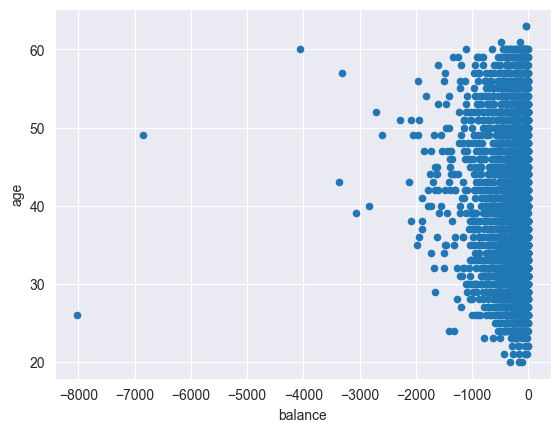

In [309]:
scatter_test = data_no_dupes[data_no_dupes['balance'] < 0]
scatter_test.plot.scatter(x='balance', y='age')

In [310]:
data_outliers = data_no_dupes[data_no_dupes['balance'] > -3500]

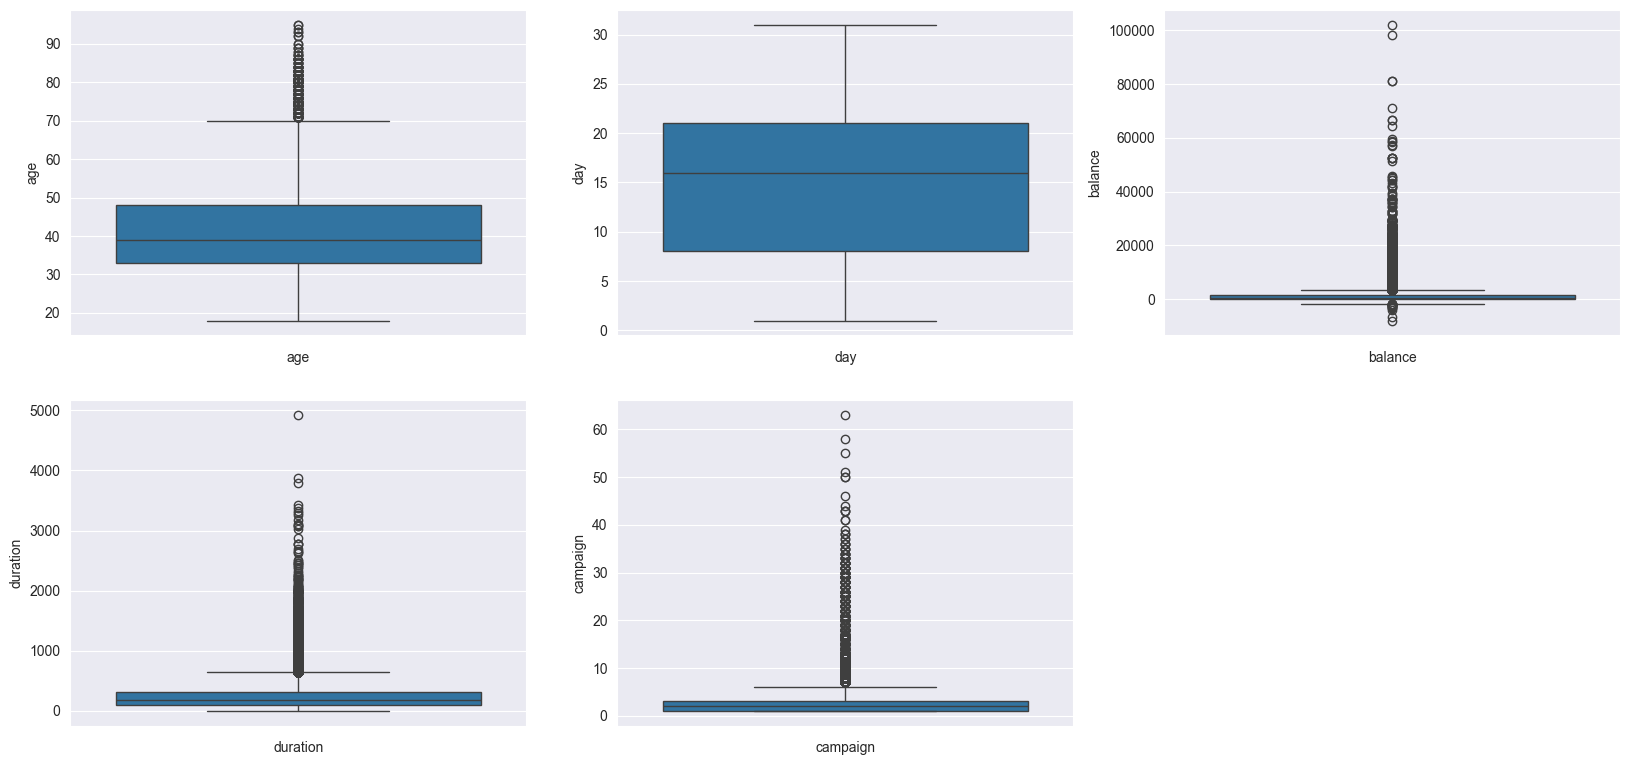

In [311]:
numerical_feats = ["age","day", "balance", "duration", "campaign"]
plt.figure(figsize=(20,60),)
plotnumber = 1
for num in numerical_feats:
    ax = plt.subplot(12,3,plotnumber)
    sns.boxplot(data_no_dupes[num])
    plt.xlabel(num)
    plotnumber += 1
plt.show()

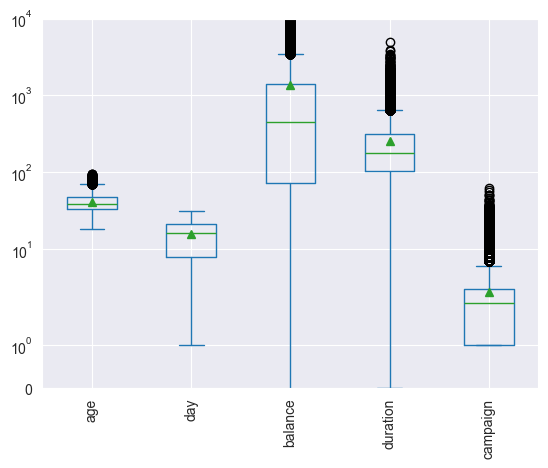

In [312]:
boxplot_data = data_no_dupes[["age","day", "balance", "duration", "campaign"]]
fig, ax = plt.subplots(1, 1)

boxplot_data.plot.box(ax=ax, rot=90, showmeans=True)

ax.set_ylim(0, 10000)
ax.set_yscale('symlog')

#### Εκκαθάριση ακραίων τιμών


In [313]:
numeric_columns_part = data_no_dupes[["age","day", "duration", "campaign"]]

def clean_outliers(data, numeric_columns_part):

        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = numeric_columns_part.quantile(0.25)
        Q3 = numeric_columns_part.quantile(0.75)

        # Calculate IQR (Inter-quantile Range)
        IQR = Q3 - Q1

        # Define the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remove rows where outliers exist for the current column
        no_outliers_mask = ((numeric_columns_part >= lower_bound) & (numeric_columns_part <= upper_bound)).all(axis=1)
        cleaned_df = data[no_outliers_mask]
        
        return cleaned_df

In [314]:
data_no_outliers = clean_outliers(data_no_dupes, numeric_columns_part)
numeric_columns_part = data_no_outliers[["age", "day", "duration", "campaign"]]

#### Έλεγχος αφαίρεσης ακραίων τιμών


In [315]:
data_no_outliers.shape

(38667, 17)

In [316]:
numeric_columns_part.describe()

,age,day,duration,campaign
count,38667.000000,38667.000000,38667.000000,38667.000000
mean,40.526237,15.527970,207.662270,2.129309
std,10.008415,8.270035,139.877358,1.319881
min,18.000000,1.000000,0.000000,1.000000
25%,32.000000,8.000000,103.000000,1.000000
50%,39.000000,16.000000,171.000000,2.000000
75%,48.000000,21.000000,281.000000,3.000000
max,70.000000,31.000000,643.000000,6.000000


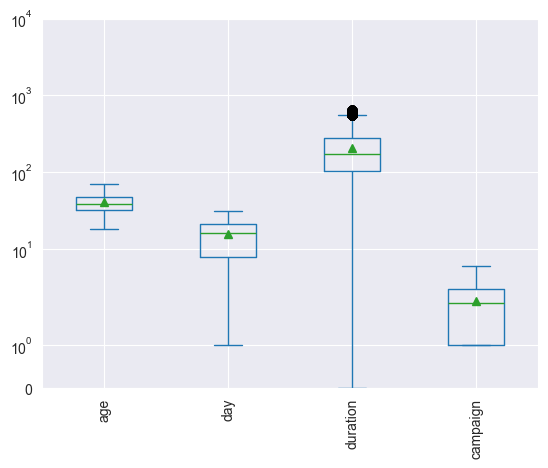

In [317]:
fig, ax = plt.subplots(1,1)

numeric_columns_part.plot.box(ax=ax, rot=90, showmeans=True)

ax.set_ylim(0, 10000)
ax.set_yscale('symlog')

#### previous
#### Η τιμή 275 είναι ξεκάθαρα outlier και θα αφαιρεθεί η αντίστοιχη εγγραφή



np.int64(275)

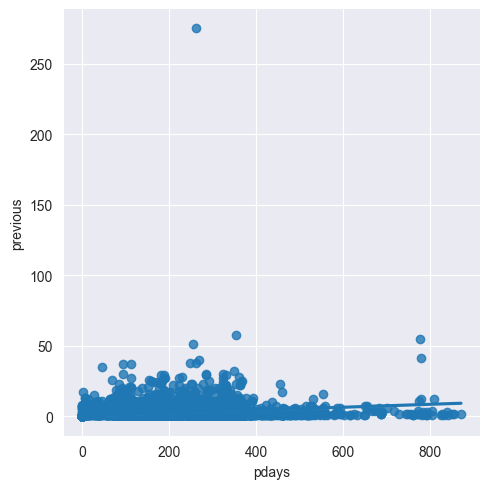

In [318]:
sns.lmplot(x="pdays", y="previous", data=data_no_dupes )
data_no_dupes.previous.max()

In [319]:
clean_data = data_no_outliers[data_no_outliers['previous'] != 275]
clean_data.shape

(38666, 17)

#### Διόρθωση του index

In [320]:
clean_data = clean_data.reset_index(drop=True)
clean_data.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
38661,34,admin.,single,secondary,no,557,no,no,cellular,17,nov,224,1,-1,0,unknown,yes
38662,23,student,single,tertiary,no,113,no,no,cellular,17,nov,266,1,-1,0,unknown,yes
38663,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,386,2,-1,0,unknown,yes
38664,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
38665,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


#### Διαμόρφωση boolean χαρακτηριστικών

In [321]:
boolean_columns = clean_data[['default', 'housing', 'loan', 'y']]
boolean_columns.head()

,default,housing,loan,y
0,no,yes,no,no
1,no,yes,no,no
2,no,yes,yes,no
3,no,yes,no,no
4,no,no,no,no


In [322]:
boolean_columns.dtypes

default    object
housing    object
loan       object
y          object
dtype: object

In [323]:
boolean_columns.default.unique()

array(['no', 'yes'], dtype=object)

#### Τα χαρακτηριστικά boolean δεν είναι ακόμα τύπου boolean, οπότε πιο κάτω θα μετασχηματιστούν.

In [324]:
clean_data['default'] = clean_data['default'].map({'yes': 1, 'no': 0})
clean_data['housing'] = clean_data['housing'].map({'yes': 1, 'no': 0})
clean_data['loan'] = clean_data['loan'].map({'yes': 1, 'no': 0})
clean_data['y'] = clean_data['y'].map({'yes': 1, 'no': 0})
clean_data.default = clean_data.default.astype('bool')
clean_data.housing = clean_data.housing.astype('bool')
clean_data.loan = clean_data.loan.astype('bool')
clean_data.y = clean_data.y.astype('bool')

In [325]:
clean_data[['default', 'housing', 'loan', 'y']].describe()

,default,housing,loan,y
count,38666,38666,38666,38666
unique,2,2,2,2
top,False,True,False,False
freq,37979,21788,32395,35283


#### Διαχείριση Κατηγορικών Χαρακτηριστικών

In [326]:
categorical_columns = clean_data[['job', 'education', 'contact','poutcome']]
categorical_columns.head()

,job,education,contact,poutcome
0,management,tertiary,unknown,unknown
1,technician,secondary,unknown,unknown
2,entrepreneur,secondary,unknown,unknown
3,blue-collar,unknown,unknown,unknown
4,unknown,unknown,unknown,unknown


In [327]:
categorical_columns.describe()

,job,education,contact,poutcome
count,38666,38666,38666,38666
unique,12,4,3,4
top,blue-collar,secondary,cellular,unknown
freq,8358,20065,25175,31298


#### Βάση των πληροφοριών που παρέχονται από την πηγή τα δεδομένα δεν περιέχουν τιμές NaN (null). Ωστόσο υπάρχουν τιμές σε κατηγορικά χαρακτηριστικά ('unknown' ή 'other') που δηλώνουν την έλλειψη πληροφορίας. Ποιο κάτω θα υπολογιστεί το πλήθος των τιμών αυτών για κάθε κατηγορικό χαρακτηριστικό και θα γίνει μία γραφική απεικόνιση, ώστε να προσδιοριστεί η κατάλληλη προσέγγιση στη συμπλήρωση τους

In [328]:
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

#### Αριθμός τιμών "unknown"

In [329]:
categorical_columns[(categorical_columns=='unknown')].count()

job            233
education     1536
contact      11274
poutcome     31298
dtype: int64

#### Γραφική Αναπαράσταση Ελλιπών τιμών ανά Χαρακτηριστικό

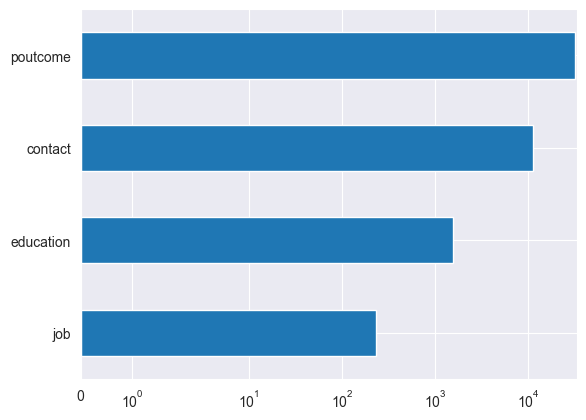

In [330]:
fig, ax = plt.subplots(1,1)
categorical_columns[(categorical_columns=='unknown')].count().plot.barh(ax=ax)

ax.set_xscale('symlog')

#### Ποσοστό εμφάνισης τιμών "unknown" για κάθε κατηγορικό χαρακτηριστικό

In [331]:
categorical_columns[(categorical_columns=='unknown')].count()*100/len(data_no_dupes)

job           0.515361
education     3.397403
contact      24.936409
poutcome     69.226516
dtype: float64

Η στήλη **poutcome** έχει υπερβολικά πολλές τιμές `unknown` (81.7%). Επειδή λείπει υπερβολικά μεγάλο ποσοστό πληροφορίας, αυτή η στήλη θα αφαιρεθεί.

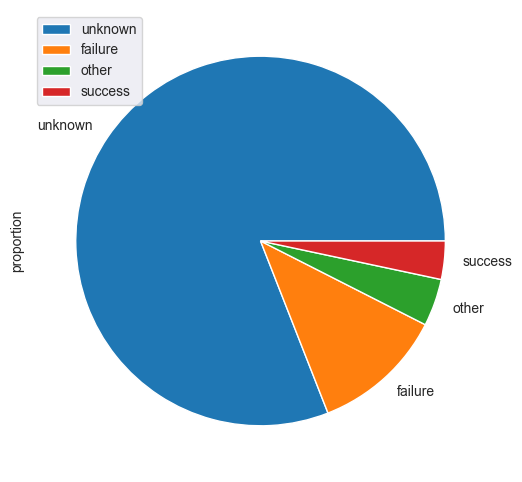

In [332]:
out = clean_data.poutcome.value_counts(sort=True, normalize=True)

fig, ax = plt.subplots(1,1, figsize=(6,6))
out.plot.pie(legend=True, ax=ax)
plt.show()

In [333]:
clean_data = clean_data.drop(columns=['poutcome'], axis=1)
clean_data.columns 

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'y'],
      dtype='object')

#### Συμπλήρωση ελλιπών τιμών (job, education)
Στα χαρακτηριστικά **'job'** και **'education'** επειδή το ποσοστό των ελλιπών τιμών είναι μικρό (0.63% και 4.1% αντίστοιχα) και άρα δε θα είχε ισχυρή επιρροή στη μέση τιμή οι ελλιπείς τιμές θα συμπληρωθούν με τη μέση τιμή (most frequent value) του αντίστοιχου χαρακτηριστικού.

In [334]:
# Calculate the mode of the 'job' column
job_mode = clean_data['job'].mode()[0]

# Replace 'unknown' values in the 'job' column with the mode
# filled_categorical_columns = categorical_columns.copy()
clean_data['job'] = clean_data['job'].replace('unknown',job_mode)

# Check
clean_data[clean_data['job']=='unknown']['job'].count()

np.int64(0)

In [335]:
# Calculate the mod of the 'education' column
education_mode = clean_data['education'].mode()[0]

# Replace 'unknown' values in the 'education' column with the mode
clean_data['education'] = clean_data['education'].replace('unknown',education_mode)

# Check
clean_data[clean_data['education']=='unknown']['education'].count()

np.int64(0)

#### contact
Το χαρακτηριστικό **'contact'** έχει ένα σημαντικό ποσοστό (28.79%) ελλιπών τιμών τα οποία αν συμπληρωθούν με την ποιο συχνή τιμή μπορεί τελικά το χαρακτηριστικό να μην αντιπροσωπεύει την πραγματικότητα. Για αυτό το λόγο θα χρησιμοποιηθούν οι πληροφορίες που παρέχουν τα υπόλοιπα χαρακτηριστικά μέσω ενός Bayesian Ταξινομητή, που θα εκπαιδευτεί στις πλήρεις γραμμές της βάσης δεδομένων για να συμπληρώσει αυτές με τις ελλειπείς τιμές.


Note: για τωρα φευγει

In [336]:
clean_data.contact.value_counts(sort=False)

contact
unknown      11274
cellular     25175
telephone     2217
Name: count, dtype: int64

In [337]:
clean_data = clean_data.drop(columns=['contact'], axis=1)
clean_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous',
       'y'],
      dtype='object')

In [338]:
# Replace 'unknown' with NaN for simplicity
# clean_data['contact'] = clean_data['contact'].replace('unknown',np.nan)

In [339]:
# df_copy = clean_data[['age','balance','contact']].dropna()
# df_copy['contact']=df_copy['contact'].map({'cellular':1, 'telephone':2})
# 
# X = df_copy[['age','balance']].to_numpy()
# Y = df_copy['contact'].to_numpy()
# 
# clf = GaussianNB()
# clf.fit(X,Y)
# 
# nan_rows = clean_data[clean_data['contact'].isna()]
# X_nan = nan_rows[['age','balance']].to_numpy()
# 
# # Find missing values
# predicted_values = clf.predict(X_nan)
# predicted_values = pd.DataFrame(predicted_values, columns=['contact'])
# 
# predicted_values['contact'] = predicted_values['contact'].map({1: 'cellular', 2: 'telephone'})
# 
# clean_data.loc[clean_data['contact'].isna(), 'contact'] = predicted_values

### Βασικά Στατιστικά Στοιχεία

In [340]:
numeric_columns = clean_data.select_dtypes(include='number')
numeric_columns.describe().round(2)

,age,balance,day,duration,campaign,pdays,previous
count,38666.00,38666.00,38666.00,38666.00,38666.00,38666.00,38666.00
mean,40.53,1336.97,15.53,207.66,2.13,42.21,0.59
std,10.01,2994.41,8.27,139.88,1.32,102.46,1.91
min,18.00,-8019.00,1.00,0.00,1.00,-1.00,0.00
25%,32.00,71.00,8.00,103.00,1.00,-1.00,0.00
50%,39.00,439.00,16.00,171.00,2.00,-1.00,0.00
75%,48.00,1400.00,21.00,281.00,3.00,-1.00,0.00
max,70.00,102127.00,31.00,643.00,6.00,871.00,58.00


#### Κατανομές συνεχών αριθμητικών χαρακτηριστικών

C:\Users\theod\AppData\Local\Temp\ipykernel_15928\3870515902.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(clean_data[feature])
C:\Users\theod\AppData\Local\Temp\ipykernel_15928\3870515902.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(clean_data[feature])
C:\Users\theod\AppData\Local

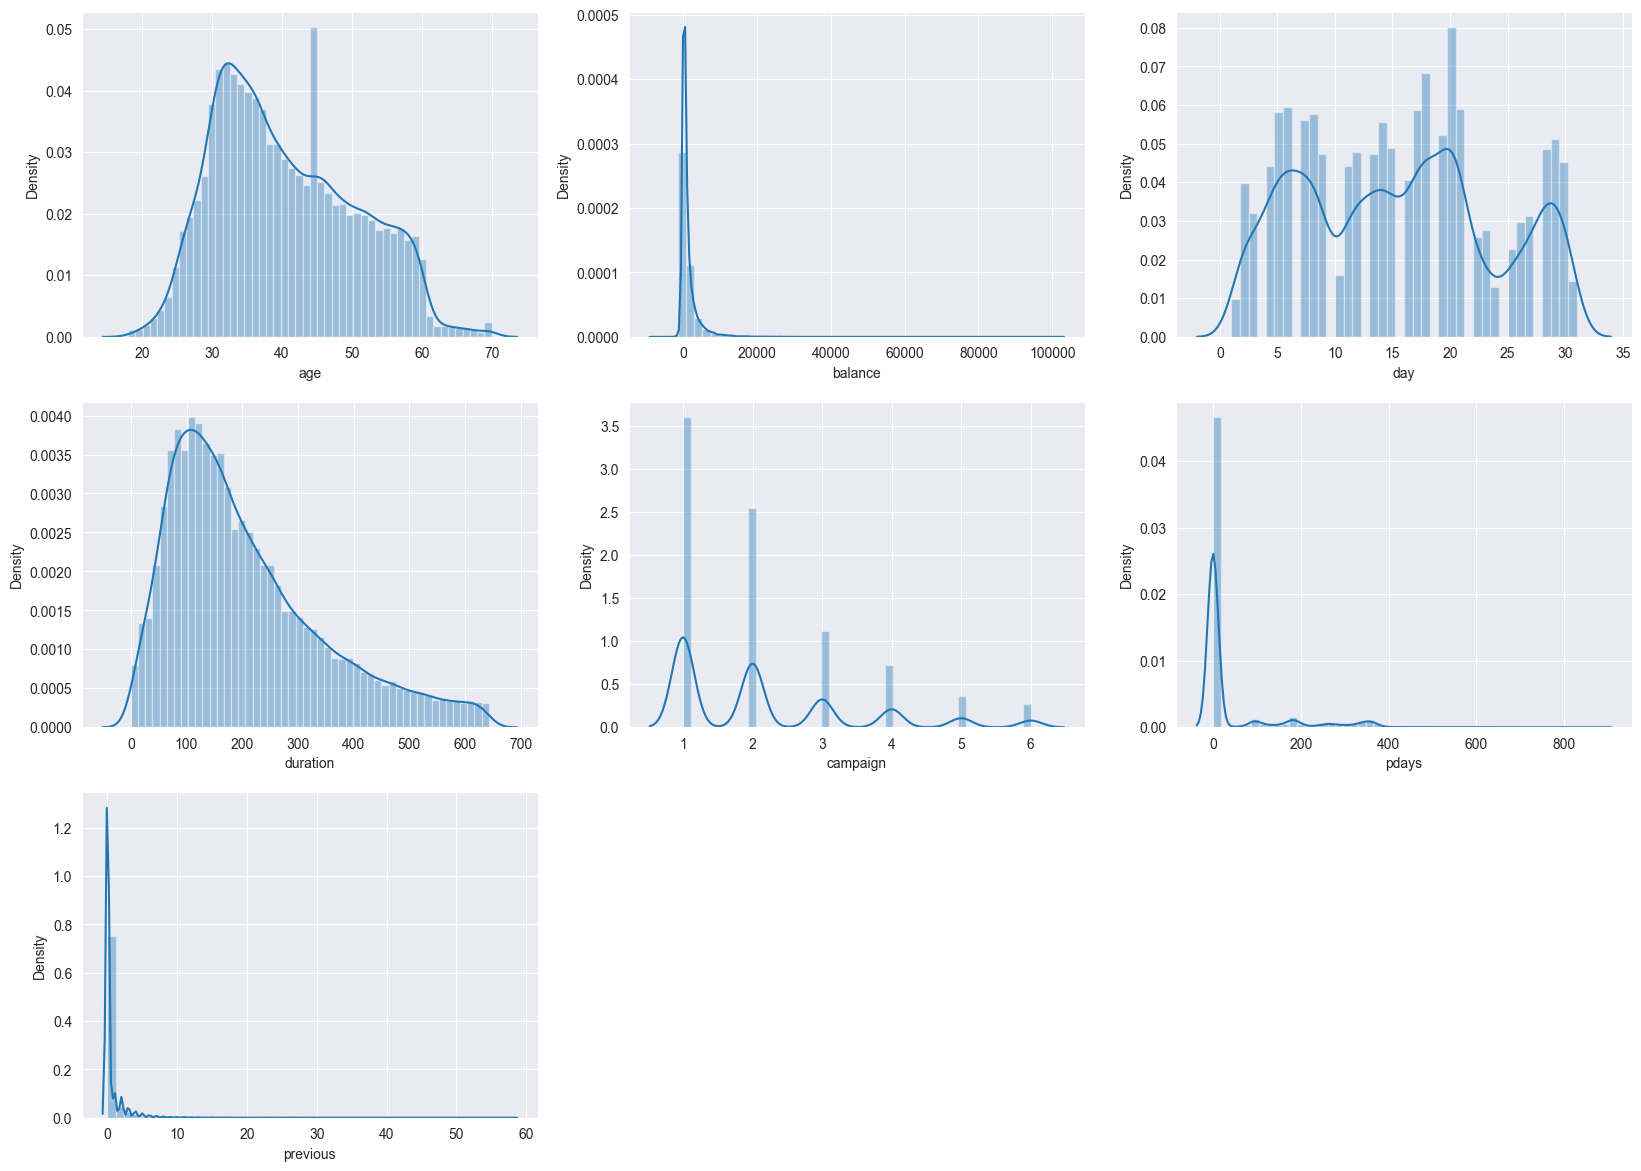

In [341]:
cont_features = ['age', 'balance', 'day' , 'duration', 'campaign', 'pdays', 'previous']

plt.figure(figsize=(20,60))
plotnumber = 1

for feature in cont_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.distplot(clean_data[feature])
    plt.xlabel(feature)
    plotnumber += 1
plt.show()

#### Balance

Text(0, 0.5, 'Customers')

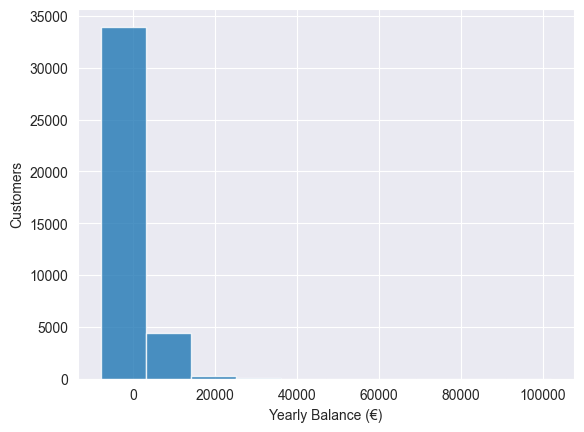

In [342]:
fig, ax = plt.subplots(1,1)

clean_data.balance.plot.hist(alpha=.8, ax=ax)
ax.set_xlabel('Yearly Balance (€)')
ax.set_ylabel('Customers')

<Axes: xlabel='balance', ylabel='age'>

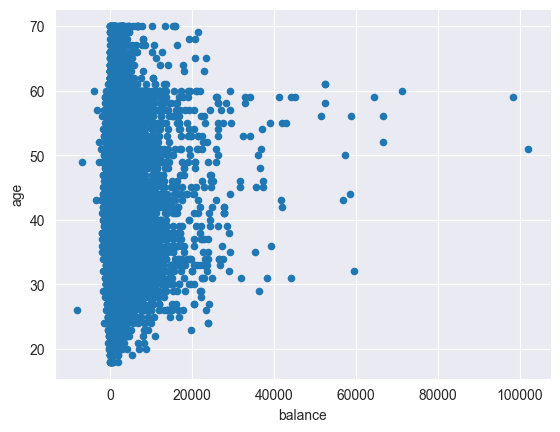

In [343]:
clean_data.plot.scatter(x='balance', y='age')

#### Jobs & Education

Text(0.5, 1.0, 'Education')

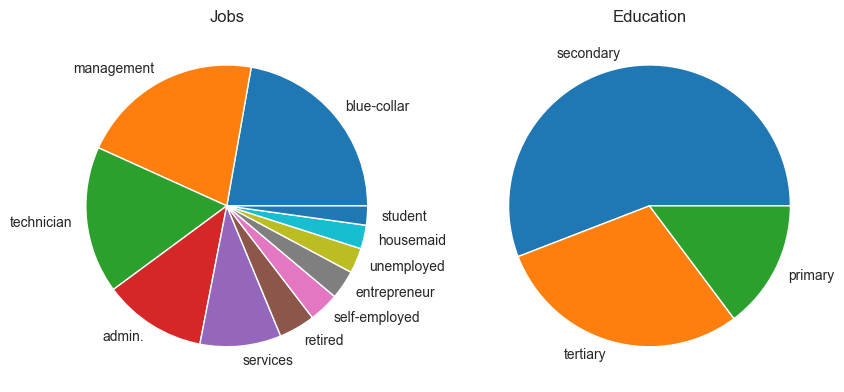

In [344]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

count = clean_data.job.value_counts(sort=True, normalize=True)
ax1.pie(count, labels=count.index)
ax1.set_title('Jobs')

count = clean_data.education.value_counts(sort=True, normalize=True)
ax2.pie(count, labels=count.index)
ax2.set_title('Education')

#### Personal & Housing Loans

Text(0.5, 1.0, 'Housing Loan')

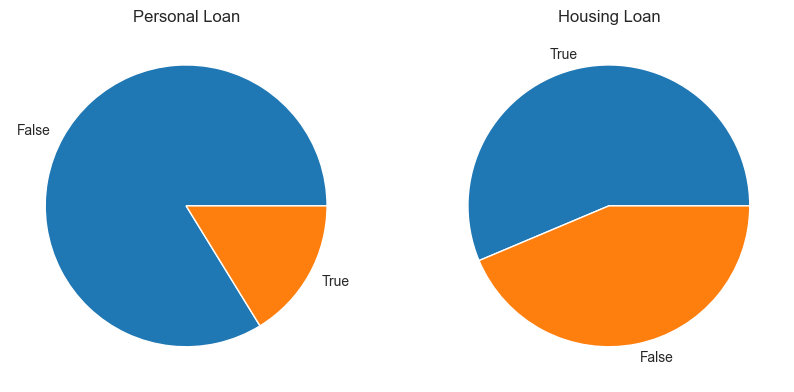

In [345]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

count = clean_data.loan.value_counts(sort=True, normalize=True)
ax1.pie(count, labels=count.index)
ax1.set_title('Personal Loan')

count = clean_data.housing.value_counts(sort=True, normalize=True)
ax2.pie(count, labels=count.index)
ax2.set_title('Housing Loan')

#### Ποσοστό πελατών με πιθανό χρέος/αρνητικές καταθέσεις

In [346]:
(numeric_columns['balance'] < 0).sum()*100/len(clean_data)

np.float64(8.392386075621994)

In [347]:
n = numeric_columns[(numeric_columns['balance']<0)].describe()
n.balance

count    3245.000000
mean     -318.098613
std       374.832134
min     -8019.000000
25%      -417.000000
50%      -229.000000
75%       -94.000000
max        -1.000000
Name: balance, dtype: float64

### Κανονικοποίηση (με RobustScaler)

In [348]:
# X = numeric_columns.to_numpy()
# transformer = RobustScaler().fit(X)
# normalized_X = transformer.transform(X)


In [349]:
# clean_numerical_columns = pd.DataFrame(normalized_X, columns= numeric_columns.columns)
# clean_numerical_columns

#### Ποσοστό επιτυχίας σε αυτή τη Marketing Καμπάνια 

In [350]:
clean_data[['y']].sum()*100/len(clean_data)

y    8.749289
dtype: float64

---
### Μείωση Διαστάσεων

#### Numeric - Correlation heatmap

<Axes: >

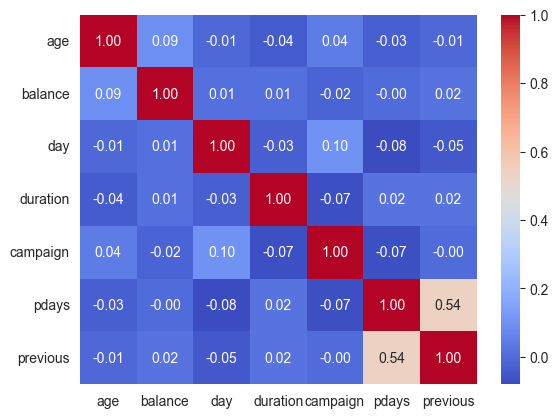

In [351]:
correlation_matrix = numeric_columns.corr().round(2)
correlation_matrix
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True,  fmt='.2f')

#### Κατηγορικά χαρακτηριστικά με y (Cramer's V)

In [352]:
def cramers_v(confusion_matrix):

    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    
    n = confusion_matrix.sum()
    phi2 = chi2/n
    
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [353]:
cm1 = pd.crosstab(clean_data['job'], clean_data['y'])
print(f'Feature {'job'}; Association \\w Target {round(cramers_v(cm1.values), 2)}')
cm2 = pd.crosstab(clean_data['education'], clean_data['y'])
print(f'Feature {'education'}; Association \\w Target {round(cramers_v(cm2.values), 2)}')
cm3 = pd.crosstab(clean_data['marital'], clean_data['y'])
print(f'Feature {'marital'}; Association \\w Target {round(cramers_v(cm3.values), 2)}')

Feature job; Association \w Target 0.14
Feature education; Association \w Target 0.09
Feature marital; Association \w Target 0.07


#### Αριθμητικά χαρακτηριστικά με y  (ANOVA test)

In [354]:
num_feats = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
for num_feat in num_feats:
    group_lists = clean_data.groupby('y')[num_feat].apply(list)
    print(f'Feature {num_feat} {"is POSSIBLY correlated" if stats.f_oneway(*group_lists).pvalue <0.05 else "is NOT correlated"} with {"y"}')

Feature age is NOT correlated with y
Feature balance is POSSIBLY correlated with y
Feature day is POSSIBLY correlated with y
Feature duration is POSSIBLY correlated with y
Feature campaign is POSSIBLY correlated with y
Feature pdays is POSSIBLY correlated with y
Feature previous is POSSIBLY correlated with y


#### Από το heatmap φαίνεται πως τα χαρακτηριστικά pdays και previous δίνουν σχετικά παρόμοιες πληροφορίες. Για τις ανάγκες της μελέτης μας, από το χαρακτηριστικό previous δεν μας ενδιαφέρει τόσο το πόσες φορές έχει υπάρξει προηγούμενη επικοινωνία, όσο το *αν* έχει υπάρξει. Το pdays μας δίνει τις μέρες που έχουν περάσει από την τελευταία επικοινωνία, με το `-1` επίσης να δηλώνει πως δεν έχει υπάρξει επικοινωνία. Επομένως, από τα δύο χαρακτηριστικά θα κρατηθεί το pdays, το οποίο στη συνέχεια θα γίνει κατηγορικό. Το previous θα γίνει boolean.

In [355]:
clean_data.pdays.describe()

count    38666.000000
mean        42.214866
std        102.455582
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: pdays, dtype: float64

#### Θα γίνει μια διακριτοποίση σχετικά με το πόσος χρόνος έχει περάσει από την προηγούμενη επικοινωνία. Για να αντλήσουμε πληροφορία σχετικά με τα νέα categorical values, θα εξετάσουμε τα στατιστικά στοιχεία του pdays εξαιρώντας τις -1 περιπτώσεις.

In [356]:
clean_data.loc[clean_data.pdays > -1, 'pdays'].describe()

count    7372.000000
mean      225.661150
std       116.093031
min         1.000000
25%       133.000000
50%       196.000000
75%       328.000000
max       871.000000
Name: pdays, dtype: float64

#### Οι νέες κατηγορικές τιμές θα διαμορφωθούν ως εξής: `never, u4m, u7m, u1y, o1y`
|value|meaning|
|-|-|
|never|Ποτέ|
|u4m|Λιγότερο από 4 μήνες|
|u7m|Λιγότερο από 7 μήνες|
|u1y|Λιγότερο από 1 χρόνο|
|o1y|Πάνω από 1 χρόνο|


In [357]:
# def pdays_to_categorical(days):
#     if days == -1:
#         return 'never'
#     elif days < 120:
#         return 'u4m'
#     elif days < 210:
#         return 'u7m'
#     elif days < 365:
#         return 'u1y'
#     elif days >= 365:
#         return 'o1y'

In [358]:
# clean_data['pdays'] = clean_data['pdays'].apply(pdays_to_categorical)

In [359]:
# out = clean_data.pdays.value_counts(sort=True, normalize=True)
# 
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# out.plot.pie(legend=True, ax=ax)
# plt.show()

#### Μετατροπή του previous σε boolean τιμή
Αρχικά όλες οι τιμές από >1 θα γίνουν 1, έτσι ώστε η στήλη να περιέχει μόνο 1 και 0. Μετά θα μετασχηματιστεί σε boolean.


In [360]:
# clean_data.loc[clean_data.previous > 1, 'previous'] = 1
# clean_data.previous.describe()

In [361]:
# clean_data.previous = clean_data.previous.astype('bool')
# clean_data.previous.describe()

In [362]:
# out = clean_data.previous.value_counts(sort=True, normalize=True)
# 
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# out.plot.pie(legend=True, ax=ax)
# plt.show()

#### duration
#### Με βάση την καθοδήγηση του dataset, για ένα predictive μοντέλο το χαρακτηριστικό duration δεν είναι πολύ χρήσιμο καθώς η διάρκεια της κλήσης δεν είναι γνωστή πριν αυτή ξεκινήσει και το αποτέλεσμα y γίνεται αυτόματα γνωστό στο τέλος της. Οπότε θα αφαιρεθεί.

In [363]:
# clean_data = clean_data.drop(columns=['duration'], axis=1)
# clean_data.columns

#### day & month
#### Καθώς η ακριβής ημερομηνία της τελευταίας επικοινωνίας δεν μας ενδιαφέρει απαραίτητα για αυτή τη μελέτη, θα αντλήσουμε τη γενικότερη εκτίμηση για το πότε αυτή συνέβη από τη μετασχηματισμένη κατηγορική στήλη pdays, και θα αφαιρέσουμε τα day, month χαρακτηριστικά.

In [364]:
# clean_data = clean_data.drop(columns=['day','month'], axis=1)
# clean_data = clean_data.reset_index(drop=True)
# clean_data.columns

In [365]:
clean_data = clean_data.reset_index(drop=True)
clean_data.to_csv('clean_data.csv')

#### Μετασχηματισμός δεδομένων

In [366]:
#One Hot encoding
df_clean, df_clean_label = pd.get_dummies(clean_data.drop('y', axis=1)), clean_data.y

#### Split

In [367]:
# Split Dataset to Train/Validation/Test Sets 
size = len(clean_data)
indices = list(range(size))

val_split = (val_size := 0.2) + (test_size := 0.2)
test_split = test_size / val_split

seed = 42

train_indices, val_indices = train_test_split(indices, test_size=val_split, random_state=seed, stratify=df_clean_label)
val_indices, test_indices = train_test_split(val_indices, test_size=test_split, random_state=seed, stratify=df_clean_label.iloc[val_indices])

df_clean_train = df_clean.iloc[train_indices].copy()
df_clean_val = df_clean.iloc[val_indices].copy()
df_clean_test = df_clean.iloc[test_indices].copy()

df_clean_y_train = df_clean_label.iloc[train_indices].copy()
df_clean_y_val = df_clean_label.iloc[val_indices].copy()
df_clean_y_test = df_clean_label.iloc[test_indices].copy()

#### Normalization

In [368]:
scaler = StandardScaler()
df_clean_train[
    ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
] = scaler.fit_transform(df_clean_train[
    ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
])

df_clean_val[
    ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
] = scaler.transform(df_clean_val[
    ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
])

df_clean_test[
    ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
] = scaler.transform(df_clean_test[
    ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
])

#### Pickle

In [369]:
# Saving Results

pd.Series({
    'X_train': df_clean_train,
    'y_train': df_clean_y_train,
    'X_val': df_clean_val,
    'y_val': df_clean_y_val,
    'X_test': df_clean_test,
    'y_test': df_clean_y_test,
    'scaler':scaler,
}).to_pickle(
    'clean-bank-data.pickle'
)

### Cell jail

In [370]:

# outliers = numeric_columns[~numeric_columns.index.isin(clean_numeric_columns.index)]
# #outliers = clean_numeric_columns

# fig, ax = plt.subplots(1,1)

# numeric_columns.plot.scatter(x='age',y='balance',ax=ax)
# # Overlay outliers as red dots on the x-axis
# # plt.scatter(outliers['balance'], np.zeros_like(outliers['balance']), color='red', marker='o', label='Outliers', zorder=5)
# outliers.plot.scatter(x='age', y='balance',color='red', marker='o', label='Outliers', zorder=5)

# ax.set_xlabel('Age')
# ax.set_ylabel('Balance ($)')

# fig, ax = plt.subplots(1,1)

# clean_numeric_columns.plot.box(ax=ax, rot=90, showmeans=True)

# ax.set_ylim(0, 10000)
# ax.set_yscale('symlog')

In [371]:
# # Initialize imputer
# imputer = KNNImputer(n_neighbors=2, weights='uniform')
# 
# # Marking 'unknown' values as NaN
# nan = np.nan
# missing_data = clean_data.replace('unknown', nan)
# 
# # Encoding    
# label_encoders = {}
# for column in missing_data.select_dtypes(include=['object']).columns:
#     le = LabelEncoder()
#     missing_data[column] = missing_data[column].astype(str)
#     missing_data[column] = le.fit_transform(missing_data[column])
#     label_encoders[column] = le
# 
# # Separating the columns to be imputed
# not_to_impute = missing_data.drop(columns=['job', 'education', 'contact'])
# columns_to_impute = missing_data[['job', 'education', 'contact']]
# 
# # Imputation
# filled_data_arr = imputer.fit_transform(columns_to_impute)
# filled_data = pd.DataFrame(filled_data_arr, columns=columns_to_impute.columns)
# 
# # Concatenation
# imputed_df = pd.concat([filled_data, not_to_impute], axis=1)
# 
# # Decode
# for column in label_encoders.keys():
#     le = label_encoders[column]
#     imputed_df[column] = le.inverse_transform(imputed_df[column].round().astype(int))
# 
# imputed_df['job', 'education', 'contact'].describe()
